# 0.0 IMPORTS


In [1]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import json
import datetime



## 0.1 Funções

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).values
  n = cm.sum()
  r, k = cm.shape
  chi2 = ss.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
  return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
  return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )
    
def cross_validation( x_training, kfold,model_name,model):
    mae_list = []
    mape_list = []
    rmse_list = []
    for fold in reversed( range( 1,kfold+1) ):
        print('\nKFold Number: {}'.format( fold ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=fold*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(fold-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset

        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

## 0.2 Carregar base de dados

In [3]:
df_sales_raw = pd.read_csv("C:/Comunidade_DS/repos/DS_Producao/datasets/train.csv", low_memory=False)
df_store_raw = pd.read_csv("C:/Comunidade_DS/repos/DS_Producao/datasets/store.csv", low_memory=False)

In [4]:
#Execução do MARGE
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left',on='Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Renomear Colunas

In [6]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
colunas_original = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [8]:
# Função para renomar colunas
snakecase = lambda x: inflection.underscore(x) # transforma os titulos para minusculos com underscore
colunas_novas = list(map(snakecase, colunas_original))
df1.columns = colunas_novas

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão dos dados

In [10]:
df1.shape

(1017209, 18)

In [11]:
print('Numero de linhas {}'.format(df1.shape[0]))
print('Numero de colunas {}'.format(df1.shape[1]))

Numero de linhas 1017209
Numero de colunas 18


## 1.3 Tipos dos dados

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# Passar a coluna de DATA de string para datetime
df1['date'] = pd.to_datetime (df1['date'])

## 1.4 Verificar os NAs

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Como proceder para a retirada dos NAs ?

1- Descartar todas as linhas com NA.

2- Usando algoritmos de ML para inserir dados.

3- Entendendo o negócio para inserir dados.

## 1.5 Preencher os NA

In [15]:
# competition_distance              
### Para todos os campos NA nesta coluna considerar e inserir o valor de 200.000 (valor máximo escolhido para este df)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )


In [16]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [17]:
# competition_open_since_month  
### Para todos os campos NA nesta coluna considerar e inserir o valor do mês da venda (Coluna "date").
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

In [18]:
# competition_open_since_year       
### Para todos os campos NA nesta coluna considerar e inserir o valor do ano da venda (Coluna "date").
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

In [19]:
# promo2_since_week 
### Para todos os campos NA nesta coluna considerar e inserir o valor da semana da venda (Coluna "date").
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

In [20]:
# promo2_since_year
### Para todos os campos NA nesta coluna considerar e inserir o valor do ano da venda (Coluna "date").
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

In [21]:
# promo_interval
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug', 9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True) # substituir todos os NA para 0 (zero)

df1['month_map'] = df1['date'].dt.month.map(month_map) # criar uma nova coluna e inserir o mês da coluna "Date" conforme a variavel "month_map"

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [22]:
df1.sample(5).T

,731120,598873,551541,500046,696493
store,466,904,402,197,404
day_of_week,6,6,6,3,2
date,2013-09-14 00:00:00,2014-01-11 00:00:00,2014-02-22 00:00:00,2014-04-09 00:00:00,2013-10-15 00:00:00
sales,3957,6071,5679,5749,3706
customers,401,586,623,797,517
open,1,1,1,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,c,c,a


In [23]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Tipos de Mudança

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [25]:
# transformar valores para inteiros
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descrição Estatística dos dados

Métricas de tendência central : 

- media e mediana
Métricas de dispersão : desvio padrão, valor minimo, valor máximo, faixa, skew(inclinação), curtose 

In [26]:
numericos = df1.select_dtypes(include=['int64','int32','float64' ])
categoricos = df1.select_dtypes(exclude=['int64','int32','float64','datetime64[ns]'])

### 1.7.1. Atributos Numéricos

In [27]:
# Métricas de tendência central 
media = pd.DataFrame ( numericos.apply(np.mean)).T
mediana = pd.DataFrame ( numericos.apply(np.median)).T

In [28]:
# Métricas de dispersão
desvio_padrao = pd.DataFrame ( numericos.apply(np.std)).T
minimo = pd.DataFrame ( numericos.apply(min)).T
maximo = pd.DataFrame ( numericos.apply(max)).T
faixa = pd.DataFrame ( numericos.apply(lambda x: x.max() - x.min())).T
inclinação = pd.DataFrame ( numericos.apply(lambda x: x.skew() )).T
curtose = pd.DataFrame ( numericos.apply(lambda x: x.kurtosis())).T

In [29]:
#Concatenar
m = pd.concat([minimo, maximo, faixa, media, mediana, desvio_padrao, inclinação, curtose ]).T.reset_index()
m.columns = ['attributes','min','max','range','mean', 'median', 'std', 'skew','kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\2399209840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'], kde=False )


<Axes: xlabel='competition_distance'>

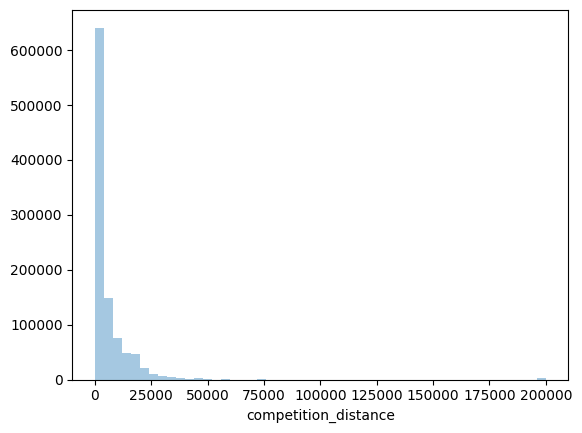

In [30]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.7.1. Atributos Categóricos

In [31]:
# Quantos niveis cada variável categorica possui ?
categoricos.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

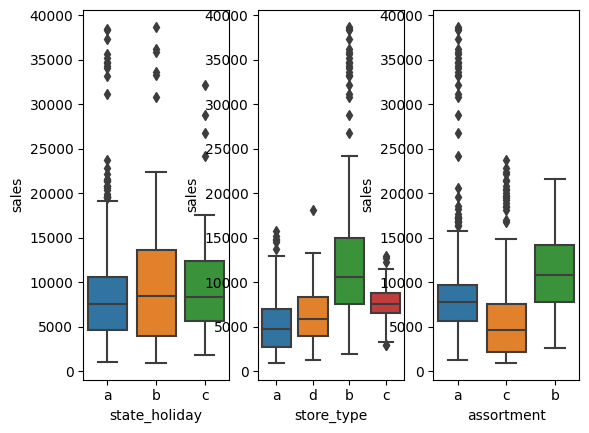

In [32]:
filtro = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=filtro )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=filtro )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=filtro )


# 2.0 FEATURE ENGINEERING

## 2.1 Mapa mental de hipóteses

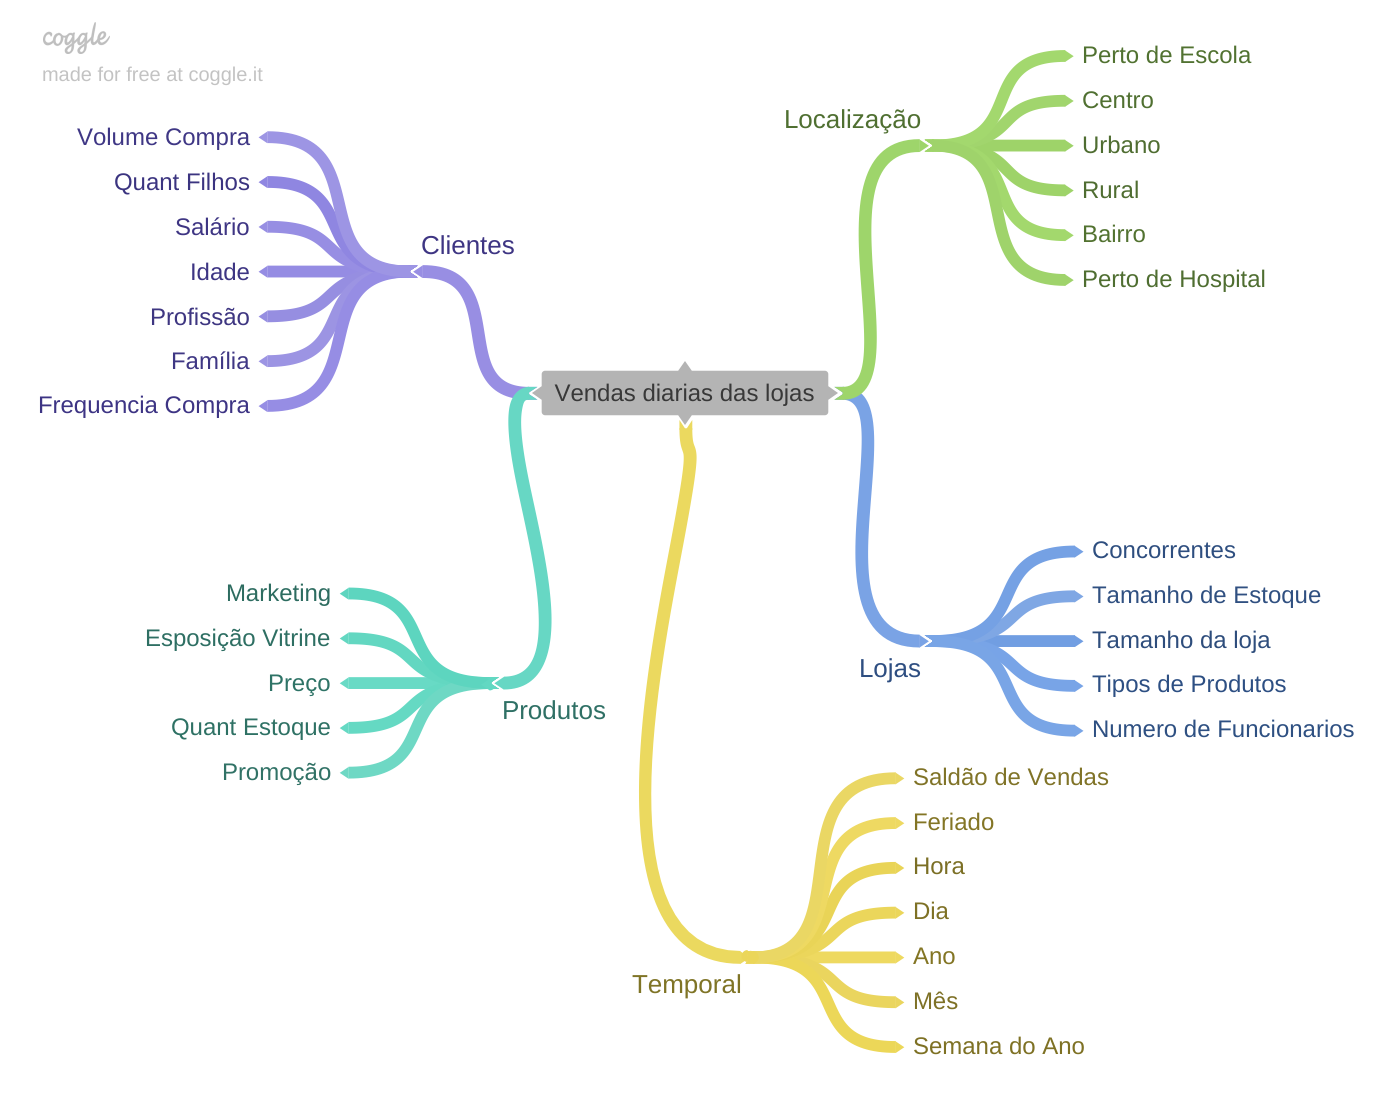

In [33]:
Image('img/mindmap.png')

## 2.2 Criação das Hipoteses

### 2.2.1 Hipoteses da loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.



### 2.2.2 Hipoteses do produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3 Hipoteses do tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Lista Final das Hipoteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [34]:
df2 = df1.copy()

In [35]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [36]:
#Ano
df2['year'] = df2['date'].dt.year

#Mês
df2['month'] = df2['date'].dt.month

#Dia
df2['day'] = df2['date'].dt.day

#Dia da Semana
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Semana no Ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Data em dias de competição
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day= 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Data em dias de promoção
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# categorias
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# feriados
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [37]:
df2.sample(5).T

,98427,322770,155740,843465,309179
store,308,443,756,196,963
day_of_week,1,2,6,3,3
date,2015-05-04 00:00:00,2014-09-30 00:00:00,2015-03-14 00:00:00,2013-06-05 00:00:00,2014-10-15 00:00:00
sales,11454,6762,17181,5256,9094
customers,1055,596,2692,712,887
open,1,1,1,1,1
promo,1,1,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,d,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [38]:
df3 = df2.copy()

In [39]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [40]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Filtragem das Colunas

In [41]:
colunas_para_dropar = ['customers', 'open', 'promo_interval','month_map']
df3 = df3.drop(colunas_para_dropar, axis=1)

In [42]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [43]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

A váriavel resposta para este projeto é a coluna "Sales"

C:\Users\VT310061\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


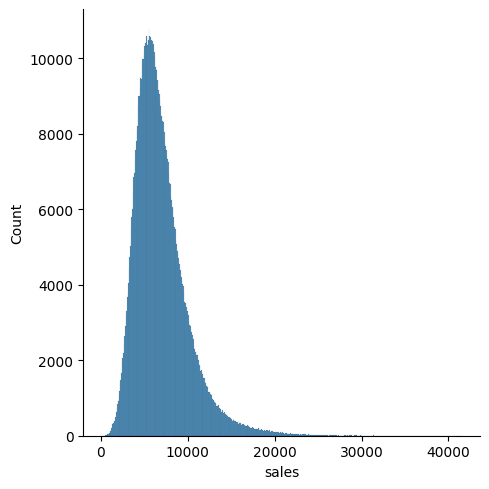

In [44]:
sns.displot(df4['sales'])

### 4.1.2 Variável numérica

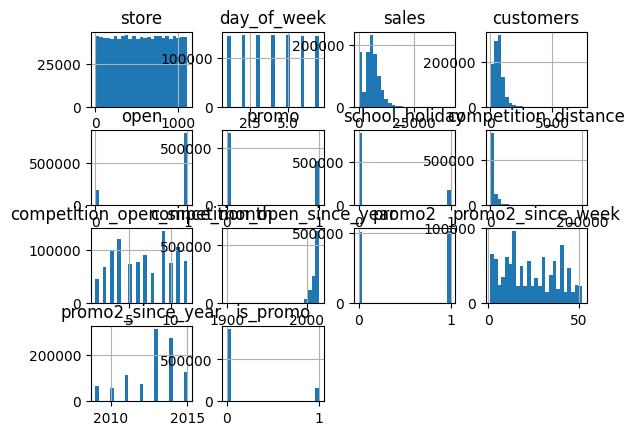

In [45]:
numericos.hist(bins=25);

### 4.1.2 Variável categórica

In [46]:
categoricos.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


<Axes: xlabel='state_holiday', ylabel='count'>

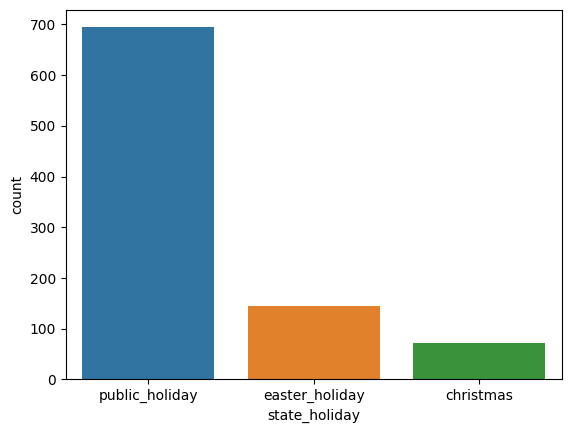

In [47]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])


<Axes: xlabel='sales', ylabel='Density'>

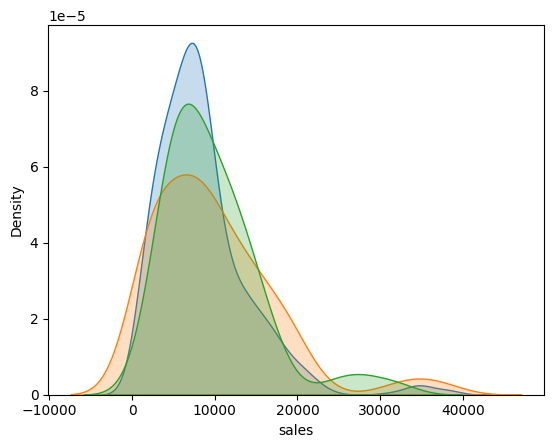

In [48]:
# state_holiday
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True )


<Axes: xlabel='store_type', ylabel='count'>

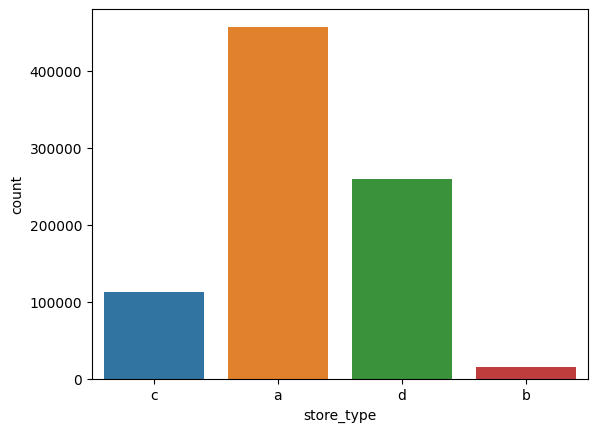

In [49]:
# store_type
sns.countplot(x=df4['store_type'])

<Axes: xlabel='sales', ylabel='Density'>

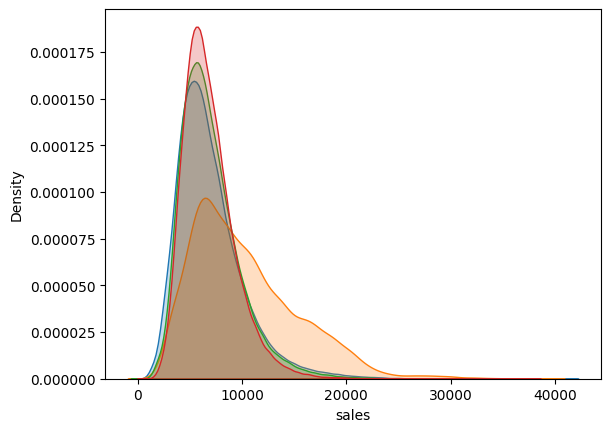

In [50]:
# store_type
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'],label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'],label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'],label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'],label='d', fill=True )

In [51]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='assortment', ylabel='count'>

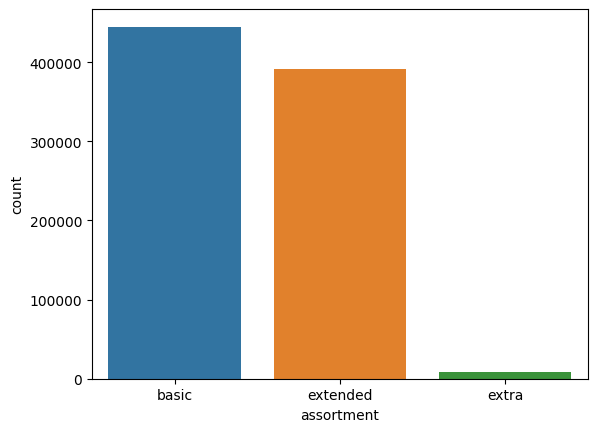

In [52]:
# assortment
sns.countplot(x=df4['assortment'])

<Axes: xlabel='sales', ylabel='Density'>

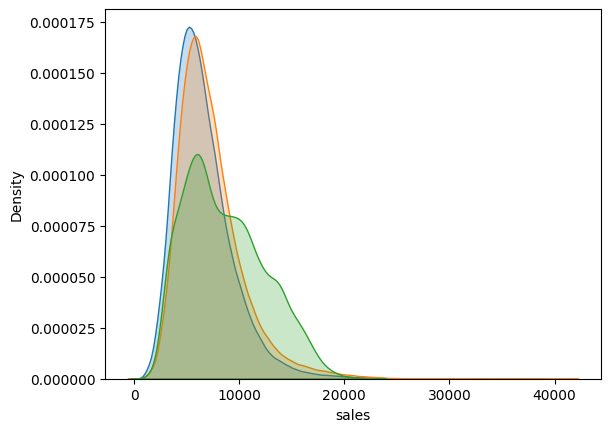

In [53]:
# assortment
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'],label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],label='extra', fill=True )

## 4.2 Análise Bivariada

#### 1. Lojas com maior sortimentos deveriam vender mais.

FALSO = O "Extra" (maior sortimento) vendem menos.

<Axes: xlabel='year_week'>

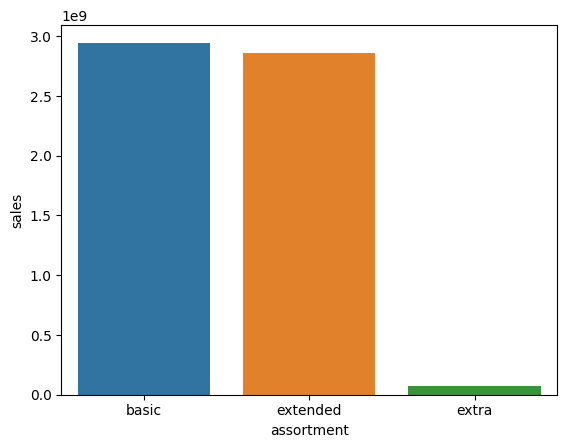

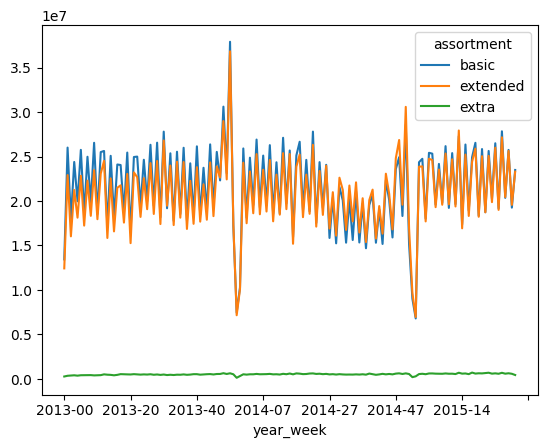

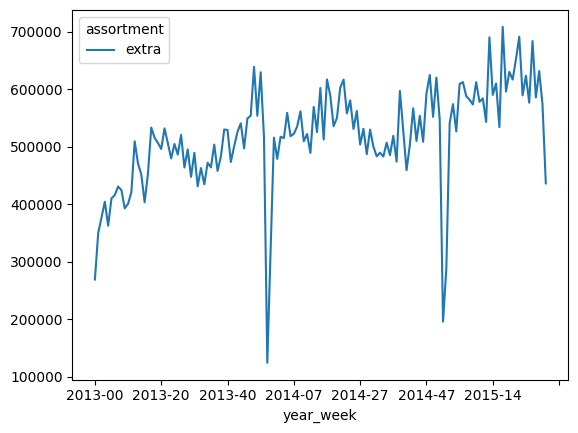

In [54]:
# total de vendas por sortimento
h1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(h1, x='assortment', y='sales')

#grafico em linha
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#Filtrando apenas a linha "extra"
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

<Axes: xlabel='year_week'>

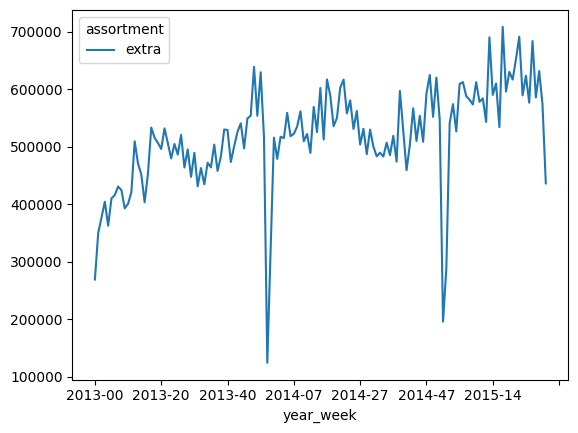

In [55]:
#Filtrando apenas a linha "extra"
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#### 2. Lojas com competidores mais próximos deveriam vender menos.

FALSO = Lojas mais próximas vendem mais

<Axes: xlabel='competition_distance', ylabel='sales'>

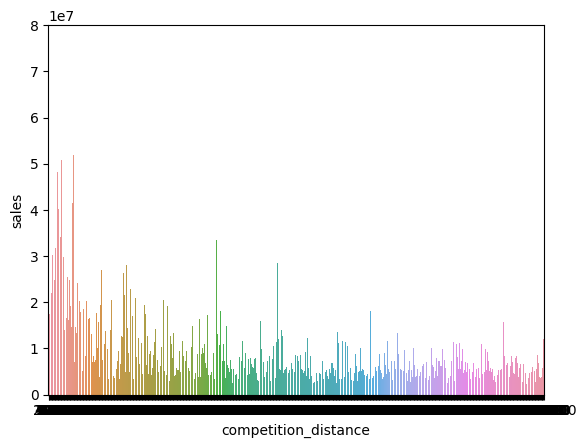

In [56]:
h2 =  df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot(h2, x='competition_distance', y='sales')




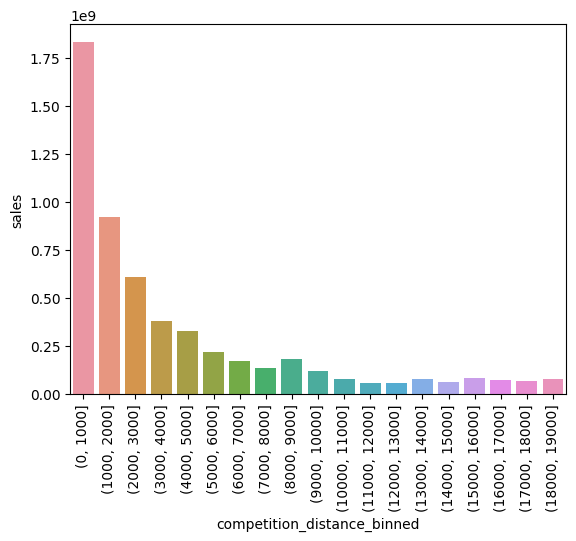

In [57]:
#criando bins
bins = list( np.arange( 0, 20000, 1000) )
h2['competition_distance_binned'] = pd.cut( h2['competition_distance'],bins=bins )

h21 = h2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=h21 )
plt.xticks( rotation=90 );

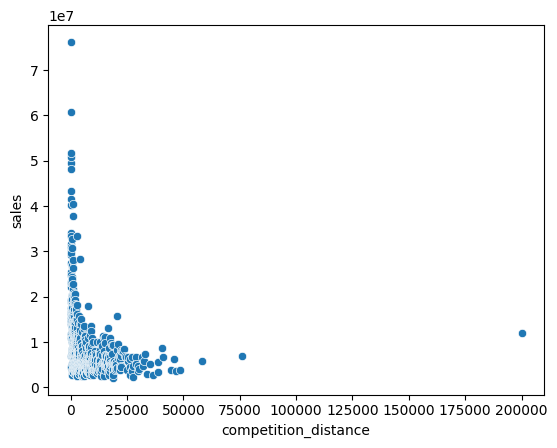

In [58]:
#grafico de bolinhas
h2 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( x ='competition_distance', y='sales', data=h2 );

<Axes: >

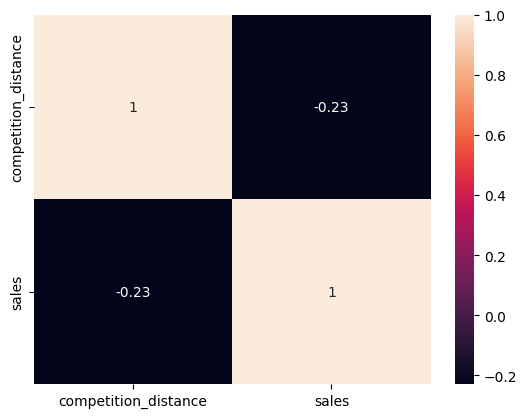

In [59]:
#Força da correlação
sns.heatmap( h2.corr( method='pearson'), annot=True )


#### 3. Lojas com competidores à mais tempo deveriam vendem mais.

FALSO = Lojas com competidores à mais tempo vendem menos

In [60]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

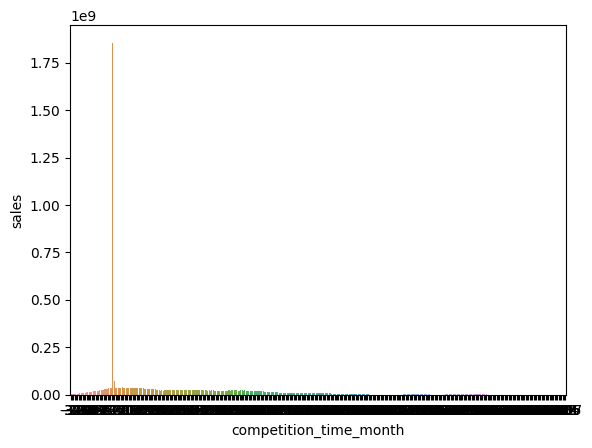

In [61]:
h3 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
sns.barplot( h3, x='competition_time_month', y='sales');

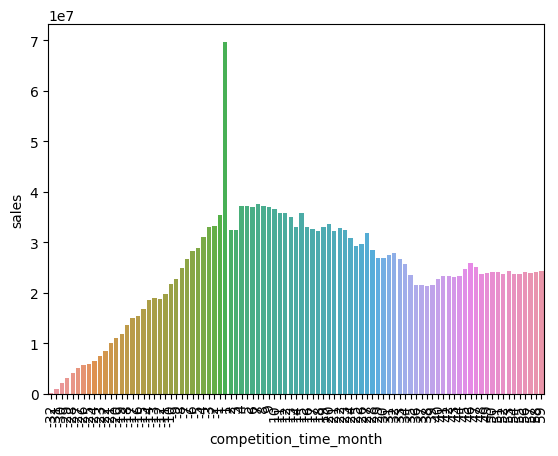

In [62]:
h3 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
h31 = h3[( h3['competition_time_month'] < 60 ) & (h3['competition_time_month'] != 0 )]
sns.barplot( h31, x='competition_time_month', y='sales', );
plt.xticks( rotation=90 );


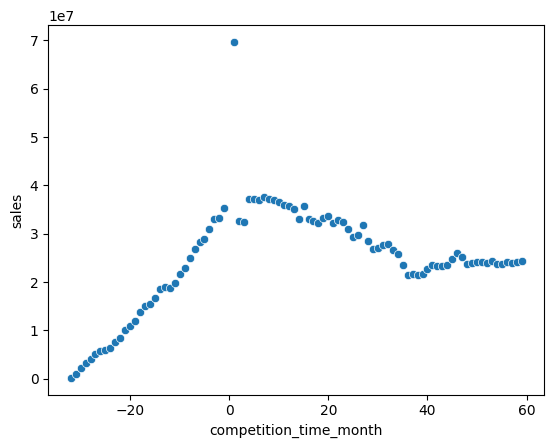

In [63]:
#grafico de bolinhas
sns.scatterplot( h31, x ='competition_time_month', y='sales');

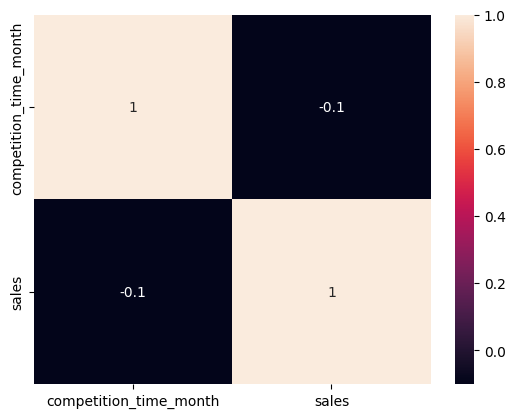

In [64]:
#Força da correlação
sns.heatmap( h3.corr( method='pearson' ), annot=True );

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

FALSO = Lojas com promoções ativas por mais tempo vendem menos

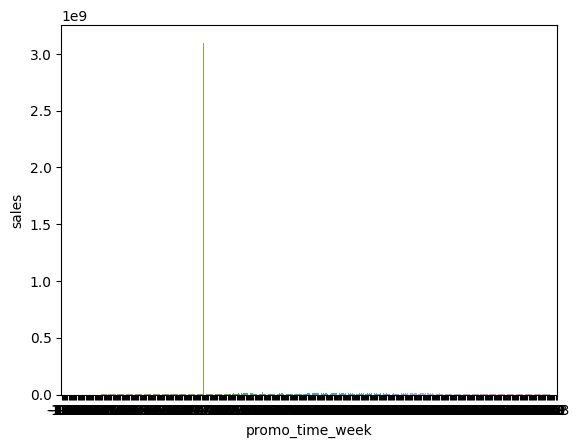

In [65]:
h4 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()
sns.barplot( h4, x='promo_time_week', y='sales');

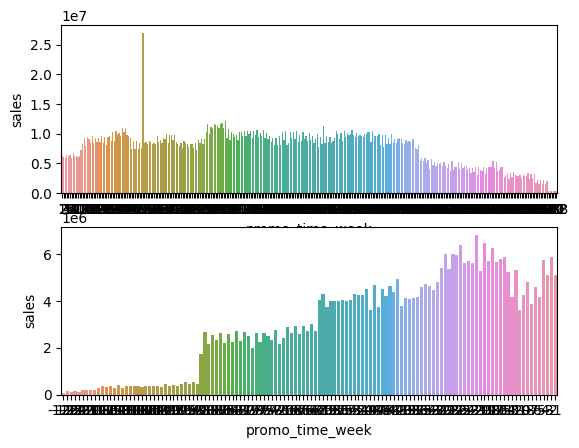

In [66]:
plt.subplot(2,1,1)
extendido = h4[h4['promo_time_week']>0] # promoção extendida
sns.barplot( extendido, x='promo_time_week', y='sales');
# as vendas caem conforme o tempo de promoção

plt.subplot(2,1,2)
regular = h4[h4['promo_time_week']<0] # promoção regular
sns.barplot( regular, x='promo_time_week', y='sales');

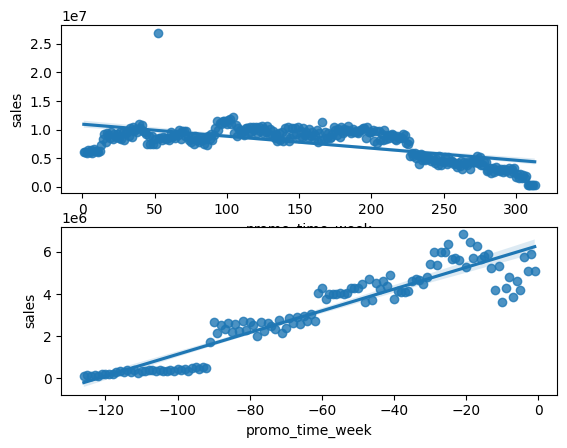

In [67]:
#grafico de bolinhas
plt.subplot(2,1,1)
sns.regplot( extendido, x='promo_time_week', y='sales');
plt.subplot(2,1,2)
sns.regplot( regular, x='promo_time_week', y='sales');

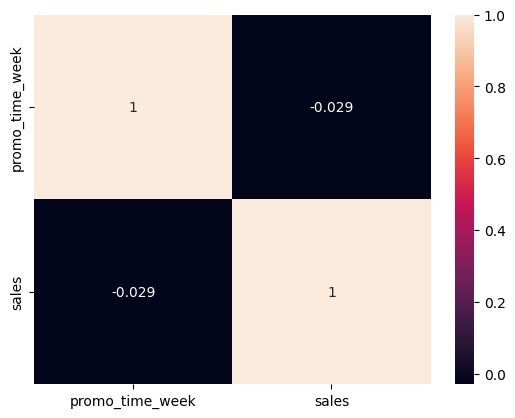

In [68]:
#Força da correlação
sns.heatmap( h4.corr( method='pearson' ), annot=True );
# para o heatmap precisa ser passado a feature inteira e não quebrada.


<s>5. Lojas com mais dias de promoção deveriam vender mais.</s>

6. Lojas com mais promoções consecutivas deveriam vender mais.

FALSA = Lojas com mais promoções consecutivas vendem menos

In [69]:
h5 = df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().sort_values('sales', ascending=False).reset_index()
h5
#quem participou da promoção extendida (promo2) vendeu menos.

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


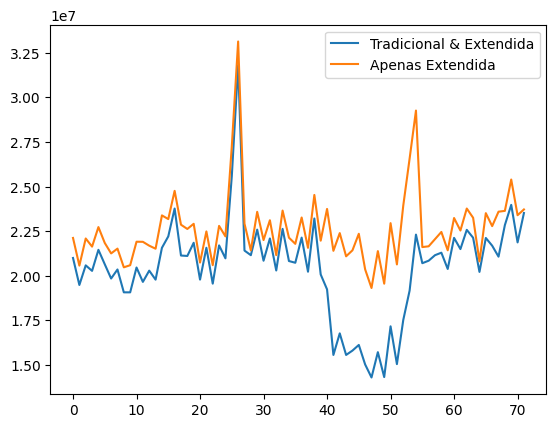

In [70]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()

aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Apenas Extendida']);


8. Lojas abertas durante o feriado de Natal deveriam vender mais.

FALSA = Lojas abertas durante o feriado de Natal não vendem mais do que os outros feriados

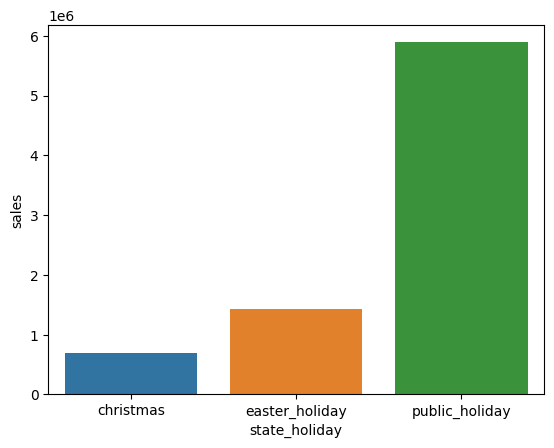

In [71]:
a1 = df4[df4['state_holiday'] != 'regular_day']
h8 = a1[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( h8, x='state_holiday', y='sales');

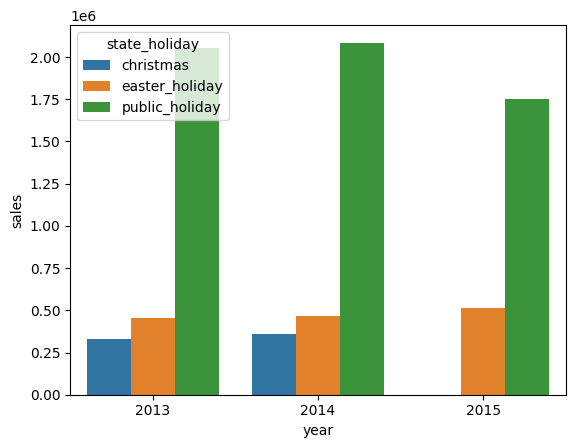

In [72]:
a2 = a1[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday']).sum().reset_index()
sns.barplot( a2, x='year', y='sales', hue='state_holiday');


9. Lojas deveriam vender mais ao longo dos anos.

FALSO = Lojas vendem menos ao logo dos anos.

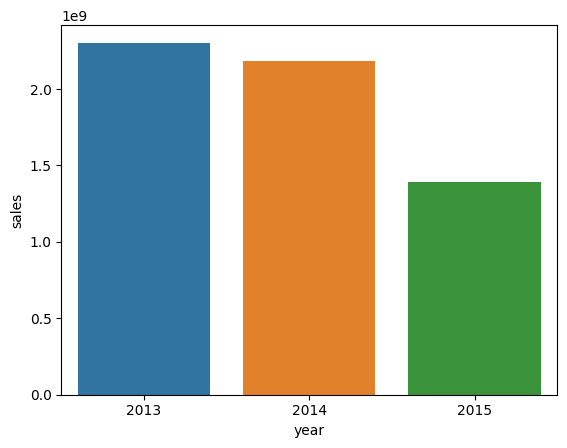

In [73]:
h9 = df4[['year', 'sales']].groupby( ['year',]).sum().reset_index()
sns.barplot( h9, x='year', y='sales');

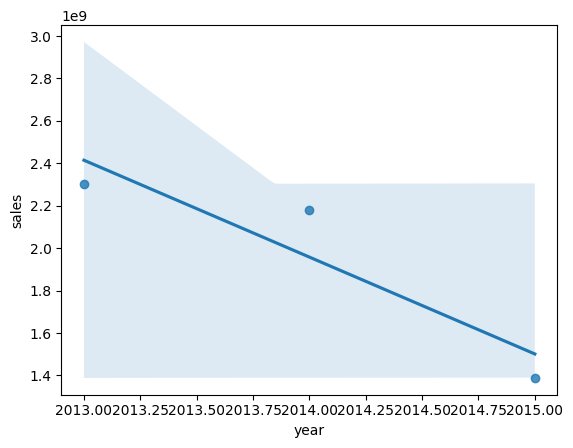

In [74]:
sns.regplot( h9, x='year', y='sales');

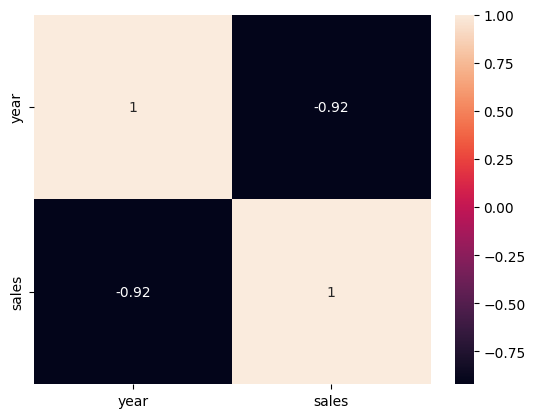

In [75]:
sns.heatmap( h9.corr( method='pearson' ), annot=True );

10. Lojas deveriam vender mais no segundo semestre do ano.

FALSO = As lojas vemde menos no segundo semestre.

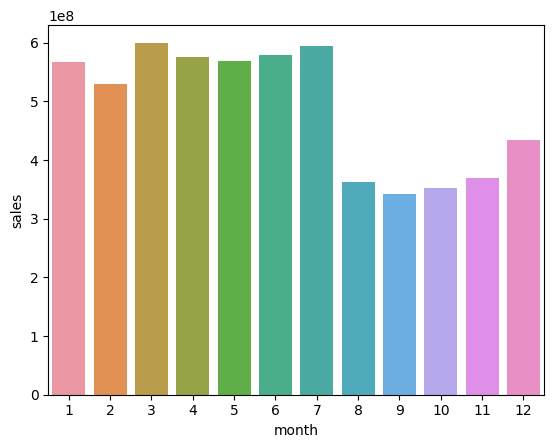

In [76]:
h10 = df4[['month', 'sales']].groupby( ['month']).sum().reset_index()
sns.barplot( h10, x='month', y='sales');

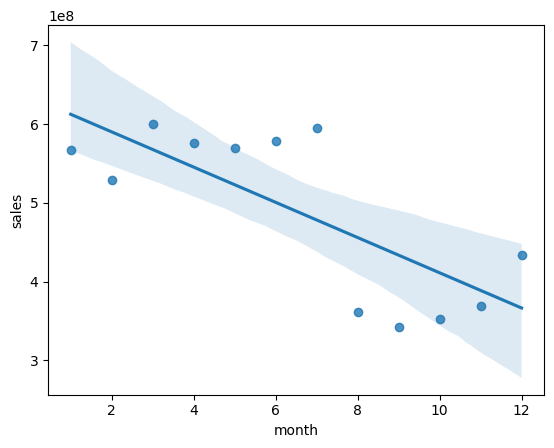

In [77]:
sns.regplot( h10, x='month', y='sales');

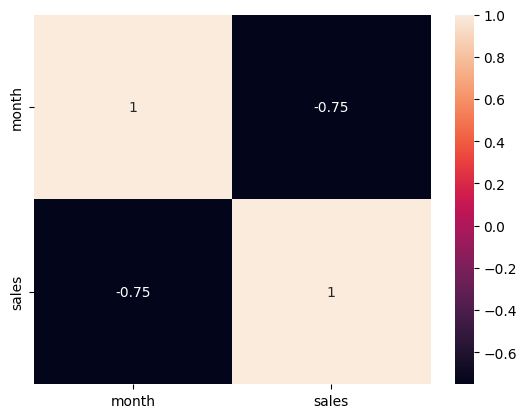

In [78]:
sns.heatmap( h10.corr( method='pearson' ), annot=True );

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

VERDADEIRA

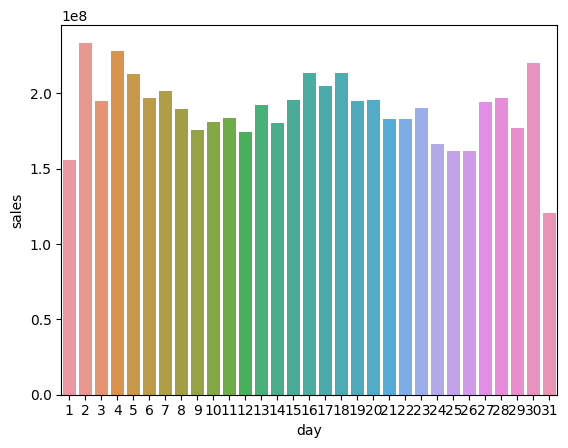

In [79]:
h11 = df4[['day', 'sales']].groupby( ['day']).sum().reset_index()
sns.barplot( h11, x='day', y='sales');

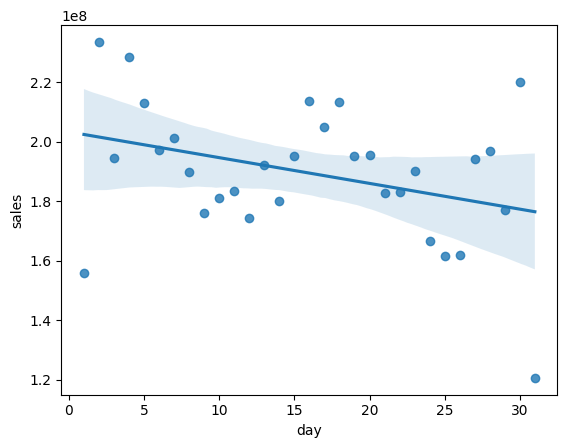

In [80]:
sns.regplot( h11, x='day', y='sales');

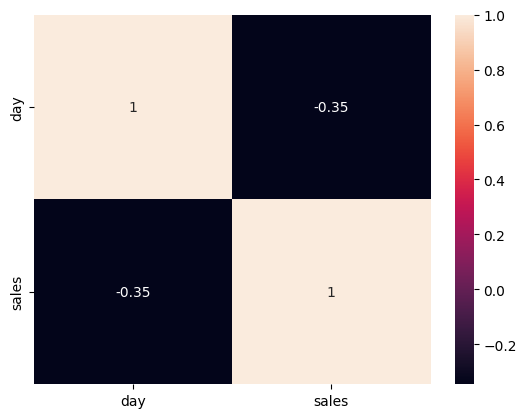

In [81]:
sns.heatmap( h11.corr( method='pearson' ), annot=True );

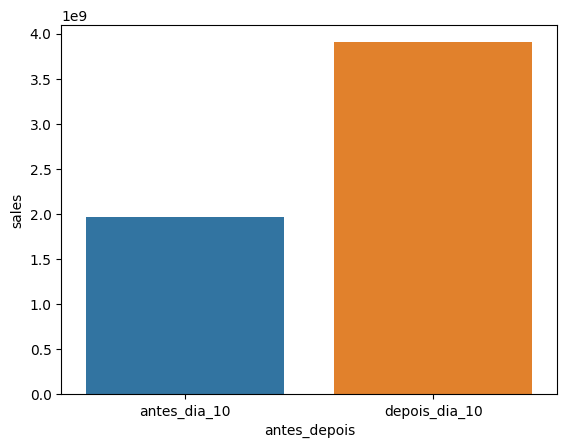

In [82]:
h11['antes_depois'] = h11['day'].apply(lambda x: 'antes_dia_10' if x <=10 else 'depois_dia_10')
h111 = h11[['antes_depois','sales']].groupby( 'antes_depois').sum().reset_index()
sns.barplot( h111, x='antes_depois', y='sales');

12. Lojas deveriam vender menos aos finais de semana.

VERDADEIRA

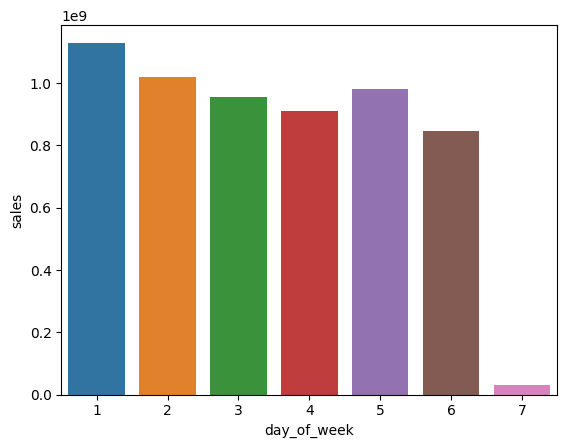

In [83]:
h12 = df4[['day_of_week', 'sales']].groupby( ['day_of_week']).sum().reset_index()
sns.barplot( h12, x='day_of_week', y='sales');

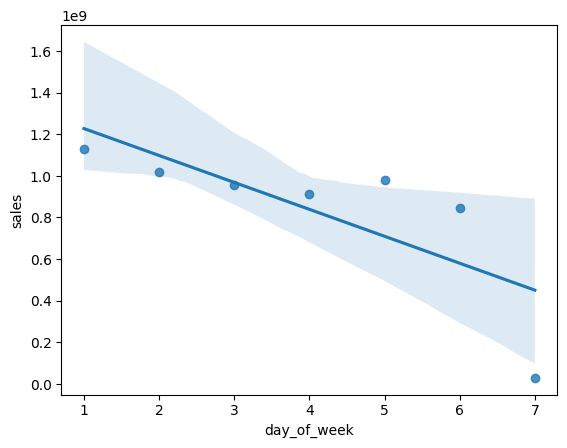

In [84]:
sns.regplot( h12, x='day_of_week', y='sales');

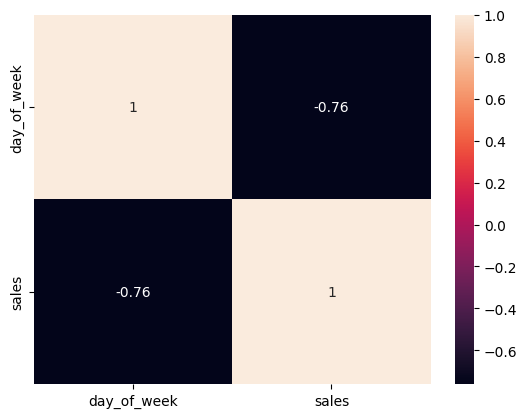

In [85]:
sns.heatmap( h12.corr( method='pearson' ), annot=True );

13. Lojas deveriam vender menos durante os feriados escolares.

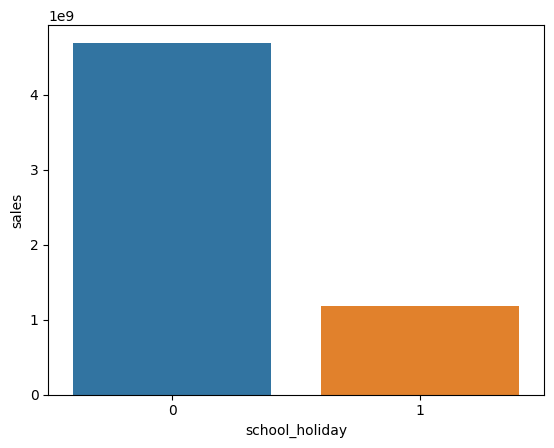

In [86]:
h13 = df4[['school_holiday', 'sales']].groupby( ['school_holiday']).sum().reset_index()
sns.barplot( h13, x='school_holiday', y='sales');

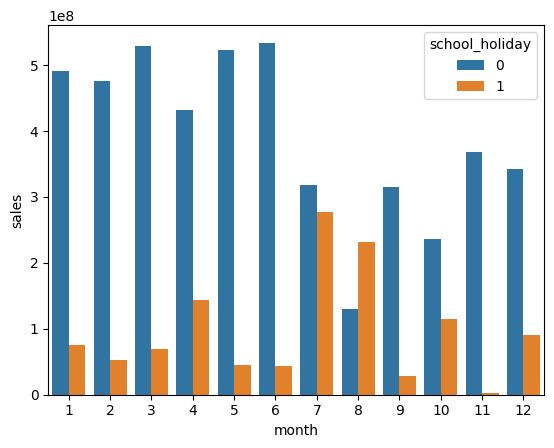

In [87]:
h131 =df4[['school_holiday', 'month', 'sales']].groupby( ['month','school_holiday']).sum().reset_index()
sns.barplot( h131, x='month', y='sales', hue='school_holiday');

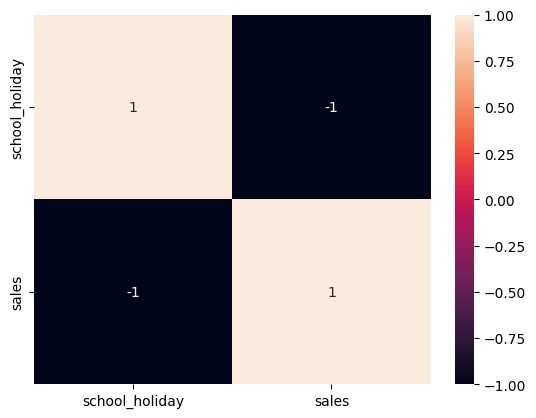

In [88]:
sns.heatmap( h13.corr( method='pearson' ), annot=True );

### 4.2.1 Resumo das hipóteses



In [89]:
from tabulate import tabulate


In [90]:

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Media'],
        ['H3', 'Falsa', 'Media'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H7', 'Falsa', 'Baixa'],
        ['H8', 'Falsa', 'Media'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Falsa', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Alta'],
        ['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

<Axes: >

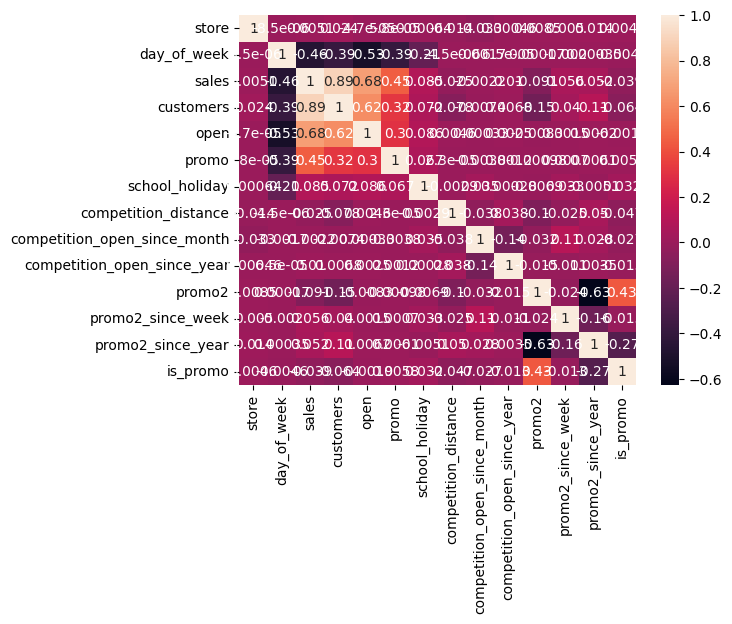

In [91]:
correlacao = numericos.corr(method='pearson')
sns.heatmap(correlacao, annot=True)

### 4.3.2 Atributos Categóricos

In [92]:
a = df4.select_dtypes(include='object')


In [93]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

<Axes: >

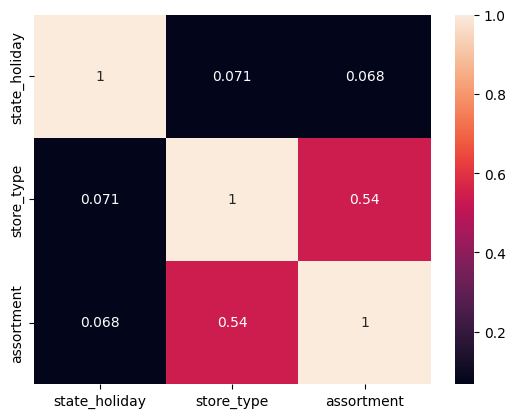

In [94]:
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 PREPARAÇÃO DOS DADOS

In [95]:
df5 = df4.copy()

## 5.1 Normalização

Normalização =  (Variavel - Média) / desvio padrão

Como encontrar as melhores variaveis ? Nos resultados da 4.1 Analise univariada e 4.1.2 Variável numérica

## 5.2 Rescaling

Min-Max Scaler = (Variavel - Média) / Valor Máximo - Valor Minimo

Robust Scaler = (Variavel - Média) / Terceiro Quartil - Primeiro Quartil

In [96]:
a = df5.select_dtypes(include=['int64','int32','float64', 'UInt32'])

In [97]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


<Axes: >

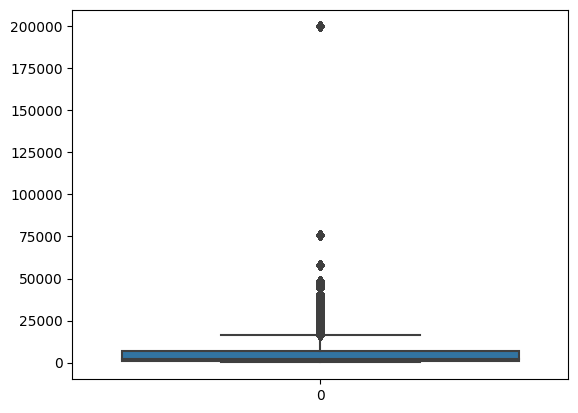

In [98]:
# competition_distance (Verificado no boxplot = possui muitos outliers)
sns.boxplot(df5['competition_distance'])

In [99]:
# Como temos muitos outliers, usaremos o robust scaler
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# Criando arquivo PKL
pickle.dump(rs, open("C:/Comunidade_DS/repos/DS_Producao/modelos/competition_distance_scaler.pkl",'wb'))

<Axes: >

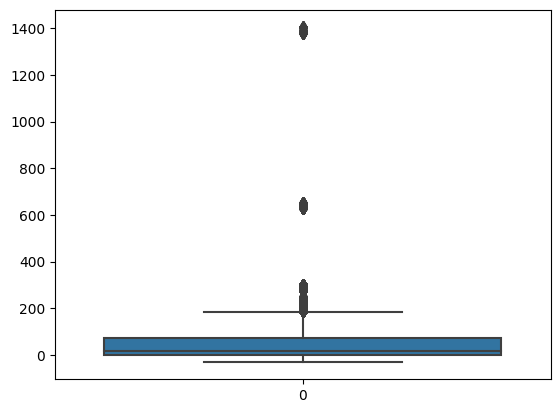

In [100]:
# competition_time_month (Verificado no boxplot = possui muitos outliers)
sns.boxplot(df5['competition_time_month'])

In [101]:
# Como temos muitos outliers, usaremos o robust scaler
rs = RobustScaler()
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open("C:/Comunidade_DS/repos/DS_Producao/modelos/competition_time_month_scaler.pkl",'wb'))

<Axes: >

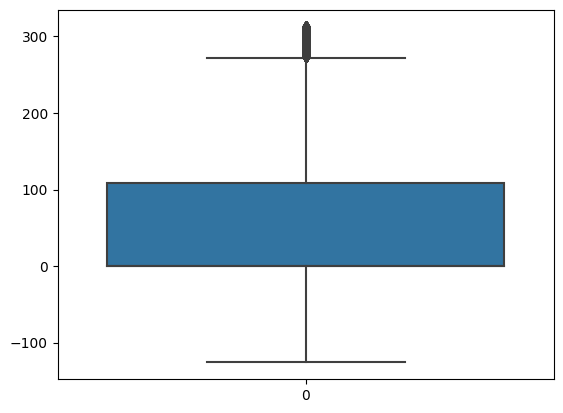

In [102]:
# promo_time_week (Verificado no boxplot = não possui muitos outliers)
sns.boxplot(df5['promo_time_week'])

In [103]:
# Como não temos muitos outliers, usaremos o min-max scaler
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open("C:/Comunidade_DS/repos/DS_Producao/modelos/promo_time_week_scaler.pkl",'wb'))

In [104]:
mms = MinMaxScaler()
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open("C:/Comunidade_DS/repos/DS_Producao/modelos/year_scaler.pkl",'wb'))

C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\123365564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['competition_distance']);


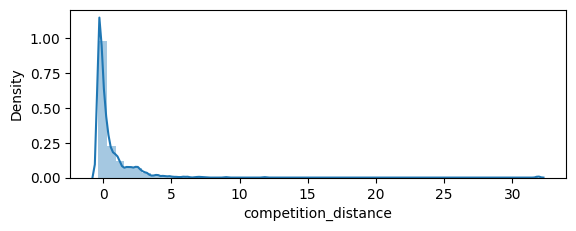

In [105]:
# como ficou agora a distribuição do competition_distance com o rubust scaler? abaixo está a original.
plt.subplot(2,1,1)
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

### 5.3.1 Encoding

One Hot Encoding - Para variáveis de estado

Label Encoding - Para variáveis de nomes

Ordinal Encoding - Segue uma ordenação numérica

Target Encoding  -Para variáveis com muitos niveis

Frequency Encoding

Embedding Encoding


In [106]:
# state_holiday - Utilizando o one-hot encodingd
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [107]:
# store_type - Utilizando o laber encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5[['store_type']])
pickle.dump(le, open("C:/Comunidade_DS/repos/DS_Producao/modelos/store_type_scaler.pkl",'wb'))

C:\Users\VT310061\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [108]:
# assortments - Utilizando o ordinal encoding
dicionario = {'basic' : 1, 'extra': 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(dicionario)

### 5.3.2 Transformação da Variavel Resposta "Sales"

Transformação Logaritmica

Box-Cox Transformation

Cube-Root Transformation

Square-Root Transformation

Sine and Cosine Transformation


C:\Users\VT310061\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


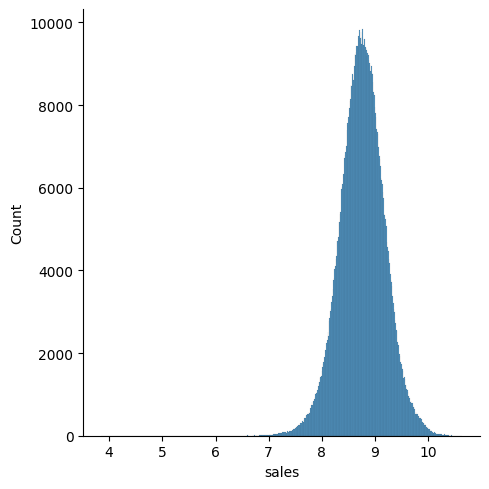

In [109]:
# Variavel Resposta é ['sales']
df5['sales']=np.log1p (df5['sales'])
sns.displot(df5['sales'])

### 5.3.3 Transformação de Natureza

In [110]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )


In [111]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. *np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. *np.pi/12 ) ) )

In [112]:
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. *np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. *np.pi/30 ) ) )

In [113]:
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. *np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. *np.pi/52 ) ) )

# 6.0 SELEÇÃO DE VARIÁVEIS

In [114]:
df6=df5.copy()

## 6.1 Dataframe de Treino e Teste

In [115]:
dropadas = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( dropadas, axis=1 )

In [116]:
# Dados de treino
x_treino = df6[df6['date'] < '2015-06-19']
y_treino = x_treino['sales']

# Dados de teste
x_teste = df6[df6['date'] >= '2015-06-19']
y_teste = x_teste['sales']

print( 'Data mínima do treino : {}'.format( x_treino['date'].min() ) )
print( 'Data máxima do treino : {}'.format( x_treino['date'].max() ) )

print( '\nData mínima do teste : {}'.format( x_teste['date'].min() ) )
print( 'Data máxima do teste : {}'.format( x_teste['date'].max() ) )



Data mínima do treino : 2013-01-01 00:00:00
Data máxima do treino : 2015-06-18 00:00:00

Data mínima do teste : 2015-06-19 00:00:00
Data máxima do teste : 2015-07-31 00:00:00


## 6.2 Boruta

In [117]:
## Dataset de treino e teste do Boruta

#x_treino_n = x_treino.drop( ['date', 'sales'], axis=1 ).values
#y_treino_n = y_treino.values.ravel()

## RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_treino_n, y_treino_n )


## 6.2.1 Colunas Escolhidas pelo Boruta

In [118]:
#cols_selected = boruta.support_.tolist()

## melhores colunas
#x_treino_fs = x_treino.drop( ['date', 'sales'], axis=1 )
#cols_boruta = x_treino_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_treino_fs.columns,֒cols_selected_boruta ) )


## 6.3 Seleção Manual de Colunas

In [119]:
cols_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

In [120]:
# inserir outras colunas
feat_to_add = ['date', 'sales']

In [121]:
# Final Features
cols_boruta_full = cols_boruta.copy()
cols_boruta_full.extend( feat_to_add )

# 7.0 TREINAMENTO DE MACHINE LEARNING

In [122]:
x_train = x_treino[ cols_boruta ]
x_test = x_teste[cols_boruta ]

# Time Series Data Preparation
x_training = x_treino[ cols_boruta_full ]


## 7.1 Modelo de Média

In [123]:
aux1 = x_test.copy()
aux1['sales'] = y_teste.copy()

In [124]:
# Predição
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'Predicao'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
y_estimado_baseline = aux1['Predicao']

In [125]:
#performance
baseline_result = ml_error( 'Modelo de Média', np.expm1( y_teste ), np.expm1(y_estimado_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Modelo de Média,1354.800353,0.455051,1835.135542


## 7.2 Modelo de Regressão Linear

In [126]:
cols_boruta_full = cols_boruta.copy()
cols_boruta_full.extend( feat_to_add )

In [127]:
lr = LinearRegression().fit(x_train,y_treino)

# prevdição
y_pred_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Regressão Linear', np.expm1( y_teste ), np.expm1(y_pred_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Regressão Linear,1867.089774,0.292694,2671.049215


### 7.2.1 Modelo de Regressão Linear - Cross Validation

In [128]:
lr_result_cv = cross_validation( x_training, 5, 'Regressão Linear', lr)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Regressão Linear,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 LASSO - Modelo de Regressão Linear Regular

In [129]:
# modelo
lrr = Lasso(alpha=0.01).fit(x_train,y_treino)

# prevdição
y_pred_lrr = lrr.predict(x_test)

# performance
lrr
lrr_result = ml_error( 'Lasso', np.expm1( y_teste ), np.expm1(y_pred_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 LASSO - Modelo de Regressão Linear Regular - Cross Validation

In [130]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [131]:
# model
rf = RandomForestRegressor( n_estimators=25, n_jobs=-1, random_state=42 ).fit(x_train,y_treino)

# prediction
yhat_rf = rf.predict( x_test )
# performance

rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_teste ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,691.50367,0.101648,1029.589939


### 7.4.1 Random Forest Regressor - Cross Validation

In [132]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,851.6 +/- 220.26,0.12 +/- 0.02,1276.42 +/- 320.01


## 7.5 XGBoost Regressor

In [133]:
# modelo
#modelo_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, learning_rate=0.01, max_depth=10, subsample=0.7,colsample_bytree=0.9  ).fit(x_train,y_treino)
modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror').fit(x_train,y_treino)

# prevdição
y_pred_xgb = modelo_xgb.predict(x_test)

# performance
xgb_result=ml_error( 'XGBoost Regressor', np.expm1( y_teste ), np.expm1(y_pred_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,860.433707,0.128868,1232.368137


### 7.5.1 XGBoost Regressor - Cross Validation

In [134]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', modelo_xgb)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0


## 7.6 Comparação do resultado de todos os modelos

### 7.6.1. Performance Simples

In [135]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,691.503670,0.101648,1029.589939
0,XGBoost Regressor,860.433707,0.128868,1232.368137
0,Modelo de Média,1354.800353,0.455051,1835.135542
0,Regressão Linear,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737


## 7.6.2 Real Performance - Cross Validation

In [136]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv,rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,851.6 +/- 220.26,0.12 +/- 0.02,1276.42 +/- 320.01
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0
0,Regressão Linear,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 FINE TUNING

## 8.1 Randon Search

In [137]:
parametros = {'n_estimators': [15,17,25,30,35],
              'learning_rate' : [0.01, 0.03],
              'max_depth': [3,5,9],
              'subsample': [0.1, 0.5,0.75],
              'colsample_bytree': [0.3, 0.5, 0.9],
              'min_child_weight' : [3,8,15]}

MAX_EVAL = 5

In [138]:
resultado_final = pd.DataFrame()

for i in range(MAX_EVAL):
    lista = { k: random.sample( v, 1 )[0] for k, v in parametros.items() }
    print( lista )

    modelo_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                                n_estimators=lista['n_estimators'], 
                                learning_rate=lista['learning_rate'], 
                                max_depth=lista['max_depth'], 
                                subsample=lista['subsample'],
                                colsample_bytree=lista['colsample_bytree'],
                                min_child_weight=lista['min_child_weight'])


    resultado = cross_validation( x_training, 5, 'XGBoost Regressor', modelo_xgb)
    resultado_final = pd.concat( [resultado_final, resultado] )

resultado_final

{'n_estimators': 17, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 15, 'learning_rate': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 15, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 17, 'learning_rate': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 25, 'learning_rate': 0.01, 'max_depth': 9, 'subsample': 0.75, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 5

KFold Numbe

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,2129.85 +/- 344.67,0.3 +/- 0.01,3057.82 +/- 501.42
0,XGBoost Regressor,2195.25 +/- 347.59,0.31 +/- 0.01,3147.4 +/- 508.77
0,XGBoost Regressor,2252.77 +/- 357.48,0.32 +/- 0.01,3201.64 +/- 514.93
0,XGBoost Regressor,2263.11 +/- 376.03,0.32 +/- 0.01,3217.53 +/- 542.57
0,XGBoost Regressor,2299.57 +/- 373.89,0.32 +/- 0.01,3260.01 +/- 536.52


## Modelo Final

In [139]:
parametros_final = {'n_estimators': 30,
              'learning_rate' : 0.03,
              'max_depth': 5,
              'subsample': 0.5,
              'colsample_bytree': 0.5,
              'min_child_weight' : 15}


In [140]:
# modelo 
modelo_xgb_tunado = xgb.XGBRegressor( objective='reg:squarederror', 
                                n_estimators=parametros_final['n_estimators'], 
                                learning_rate=parametros_final['learning_rate'], 
                                max_depth=parametros_final['max_depth'], 
                                subsample=parametros_final['subsample'],
                                colsample_bytree=parametros_final['colsample_bytree'],
                                min_child_weight=parametros_final['min_child_weight']).fit(x_train,y_treino)

# predição
y_pred_xgb_tunado = modelo_xgb_tunado.predict(x_test)

# performance
xgb_result_tunado = ml_error( 'XGBoost Regressor', np.expm1( y_teste ), np.expm1(y_pred_xgb_tunado) )
xgb_result_tunado

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1934.684067,0.294208,2804.296833


In [141]:
pred = modelo.predict( test_data )

# join pred into the original data
original_data['prediction'] = np.expm1( pred )

return original_data.to_json( orient='records', date_format='iso' )

NameError: name 'modelo' is not defined

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [142]:
df9 = x_teste[cols_boruta_full]

# Ajustar para escala original (rescale)
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(y_pred_xgb_tunado)

C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\2022282099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\2022282099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(y_pred_xgb_tunado)


## 9.1 Performance de Negócio

In [143]:
# Soma das predições
soma = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_mae = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error (x['sales'],x['predictions'] )).reset_index().rename(columns={0:'MAE'})
df9_mape = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error (x['sales'],x['predictions'] )).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_merge = pd.merge(df9_mae,df9_mape,how='inner', on='store')
df_mergeado = pd.merge(soma,df9_merge,how='inner', on='store')

# Cenários
df_mergeado['pior_cenario'] = df_mergeado['predictions'] - df_mergeado['MAE']
df_mergeado['melhor_cenario'] = df_mergeado['predictions'] + df_mergeado['MAE']

#Ordenação Colunas
df_mergeado = df_mergeado[['store','predictions', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]




In [144]:
df_mergeado.sort_values('MAPE', ascending=False).head(10)

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
542,543,237765.984375,233987.011811,241544.956939,3778.972564,1.767968
306,307,230572.937500,226983.560613,234162.314387,3589.376887,1.645500
969,970,225441.000000,222128.756559,228753.243441,3312.243441,1.529859
197,198,198814.765625,196223.528624,201406.002626,2591.237001,1.507767
840,841,216188.531250,212873.895059,219503.167441,3314.636191,1.475173
424,425,248805.953125,245245.251636,252366.654614,3560.701489,1.256725
971,972,234689.781250,231610.516707,237769.045793,3079.264543,1.205535
434,435,235791.062500,232409.168932,239172.956068,3381.893568,1.204698
955,956,222988.312500,220039.331028,225937.293972,2948.981472,1.191063
702,703,240451.640625,237045.596297,243857.684953,3406.044328,1.181214


<Axes: xlabel='store', ylabel='MAPE'>

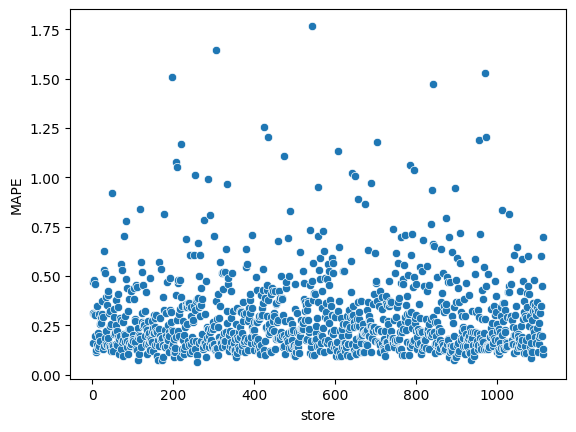

In [145]:
sns.scatterplot( x='store', y='MAPE', data=df_mergeado )

## 9.2 Performance Total

In [146]:
total = df_mergeado[['predictions', 'pior_cenario', 'melhor_cenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
total['Values'] = total['Values'].map( 'R${:,.2f}'.format )
total

,Scenario,Values
0,predictions,"R$264,043,968.00"
1,pior_cenario,"R$261,888,783.38"
2,melhor_cenario,"R$266,199,157.12"


## 9.2 Performance Machine Learning

In [147]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\VT310061\AppData\Local\Temp\ipykernel_5632\4191803207.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df9['error'] )


<Axes: xlabel='predictions', ylabel='error'>

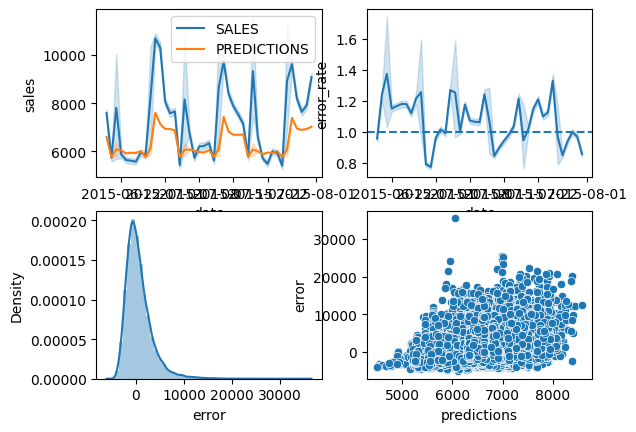

In [148]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x=df9['predictions'],y=df9['error'])

# 10.0. DEPLOY PARA PRODUÇÃO

In [149]:
pickle.dump(modelo_xgb_tunado, open("C:/Comunidade_DS/repos/DS_Producao/modelos/modelo_rossmann.pkl",'wb'))

## 10.1 CLASS ROSSMANN

In [150]:
class rossmann (object):
    def __init__ (self):
        self.home.path = "C:/Comunidade_DS/repos/DS_Producao/"
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameters/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameters/store_type_scaler.pkl', 'rb'))



    def limpeza_dados(self,df1):
        
        colunas_original = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                            'CompetitionDistance', 'CompetitionOpenSinceMonth',
                            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                            'Promo2SinceYear', 'PromoInterval']
                            
        snakecase = lambda x: inflection.underscore(x) 
        colunas_novas = list(map(snakecase, colunas_original))
        df1.columns = colunas_novas
        
        # Passar a coluna de DATA de string para datetime
        df1['date'] = pd.to_datetime (df1['date'])
        
        # competition_distance              
        ### Para todos os campos NA nesta coluna considerar e inserir o valor de 200.000 (valor máximo escolhido para este df)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )
        
        # competition_open_since_month  
        ### Para todos os campos NA nesta coluna considerar e inserir o valor do mês da venda (Coluna "date").
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
        
        # competition_open_since_year       
        ### Para todos os campos NA nesta coluna considerar e inserir o valor do ano da venda (Coluna "date").
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

        # promo2_since_week 
        ### Para todos os campos NA nesta coluna considerar e inserir o valor da semana da venda (Coluna "date").
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

        # promo2_since_year
        ### Para todos os campos NA nesta coluna considerar e inserir o valor do ano da venda (Coluna "date").
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        # promo_interval
        month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug', 9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True) # substituir todos os NA para 0 (zero)
        df1['month_map'] = df1['date'].dt.month.map(month_map) # criar uma nova coluna e inserir o mês da coluna "Date" conforme a variavel "month_map"
        df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        # transformar valores para inteiros
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
        
    def feature_engineering(self,df2):
        
        #Ano
        df2['year'] = df2['date'].dt.year

        #Mês
        df2['month'] = df2['date'].dt.month

        #Dia
        df2['day'] = df2['date'].dt.day

        #Dia da Semana
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # Semana no Ano
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # Data em dias de competição
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day= 1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # Data em dias de promoção
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        # categorias
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # feriados
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        # Filtragem das linhas e colunas

        df2 = df2[(df2['open'] != 0)]

        colunas_para_dropar = ['open', 'promo_interval','month_map']
        df2 = df2.drop(colunas_para_dropar, axis=1)
        
        return df2
        
    def preparacao (self,df5):
        
        #competition_distance
        df5['competition_distance'] = self.competition_distance.scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month']= self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week']= self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year']= self.year_scaler.fit_transform(df5[['year']].values)

        # state_holiday (one hot encoding)
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - ordinal encoding
        dicionario = {'basic':1, 'extra':2,'extended':3 }
        df5['assortment'] = df5['assortment'].map(dicionario)

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. *np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. *np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        cols_boruta = ['store',
                            'promo',
                            'store_type',
                            'assortment',
                            'competition_distance',
                            'competition_open_since_month',
                            'competition_open_since_year',
                            'promo2',
                            'promo2_since_week',
                            'promo2_since_year',
                            'competition_time_month',
                            'promo_time_week',
                            'day_of_week_sin',
                            'day_of_week_cos',
                            'month_sin',
                            'month_cos',
                            'day_sin',
                            'day_cos',
                            'week_of_year_sin',
                            'week_of_year_cos']

        return df5[cols_boruta]   
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' ) 
    


## 10.2 API HANDLER

In [151]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann


ModuleNotFoundError: No module named 'rossmann'

In [152]:
# carregar o modelo atual
modelo = pickle.load( open("C:/Comunidade_DS/repos/DS_Producao/modelos/modelo_rossmann.pkl", 'rb') )


In [153]:
# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        # Instantiate Rossmann class
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( modelo, test_raw, df3 )
        return df_response
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.128.16.39:5000
Press CTRL+C to quit


## 10.3 API de TESTE

In [210]:
# carregar o dataset de teste
df10 = pd.read_csv( "C:/Comunidade_DS/repos/DS_Producao/datasets/test.csv" )

In [211]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20,22,23] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] #lojas diferentes de zero
df_test = df_test.drop( 'Id', axis=1 )

In [212]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [213]:
# API Call

url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status Code {}' .format(r.status_code))


Status Code 200


In [214]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys()  )

In [216]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'A loja {} deverá vender R${:,.2f} nas próximas 6 semanas'.format(d2.loc[i, 'store'],d2.loc[i, 'prediction'] ) )


A loja 20 deverá vender R$265,335.72 nas próximas 6 semanas
A loja 22 deverá vender R$237,552.16 nas próximas 6 semanas
A loja 23 deverá vender R$272,546.08 nas próximas 6 semanas
